## 1.sobel filtre  et la mise en corresepandace avec cross-correlation-normalized

1. **Application de Filtres de Sobel**
   - Deux filtres de Sobel sont utilisés pour calculer le gradient des images dans les directions horizontale et verticale.

2. **Calcul du Gradient**
   - La fonction `compute_gradient(image)` calcule le gradient de chaque image en appliquant les filtres de Sobel. Le gradient est calculé comme la norme Euclidienne des gradients horizontaux et verticaux.

3. **Corrélation Croisée Normalisée**
   - La fonction `normalized_cross_correlation(image1, image2)` calcule la corrélation croisée normalisée entre deux images en utilisant la corrélation croisée standard après normalisation des images par leur moyenne et écart-type.

4. **Calcul de la Disparité**
   - La fonction `compute_disparity(correlation)` calcule la disparité entre les deux images en trouvant l'indice de la corrélation maximale pour chaque ligne, puis en soustrayant cet indice de l'indice de colonne correspondant.

5. **Affichage des Résultats**
   - Les images originales avec les gradients calculés sont affichées côte à côte.
   - Le point de correspondance maximale est marqué sur chaque image.
   - Une ligne reliant les points de correspondance maximale est dessinée pour visualiser la disparité.

Contraintes de mise en correspondance :

- Épipolaire : Toutes les droites de projection doivent passer par l'épipolaire pour réduire la recherche 2D en 1D.
- Unicité : Une seule image est primitive.
- Ordre : L'ordre doit être respecté pour les orientations.
- Disparité : p(g) ——> p(d) ≡ Correspond au raffinement
            (u(g), v(g))    (u(d), v(d))
             Σ (u(g) - u(d)) + (v(d) - v(g))




Chargement et prétraitement de la paire d’images :


Similarity percentage: 2.842611262681027%
Disparity: [[-142 -141 -140 ...  367  368  369]
 [-142 -141 -140 ...  367  368  369]
 [-147 -146 -145 ...  362  363  364]
 ...
 [-387 -386 -385 ...  122  123  124]
 [-386 -385 -384 ...  123  124  125]
 [-386 -385 -384 ...  123  124  125]]


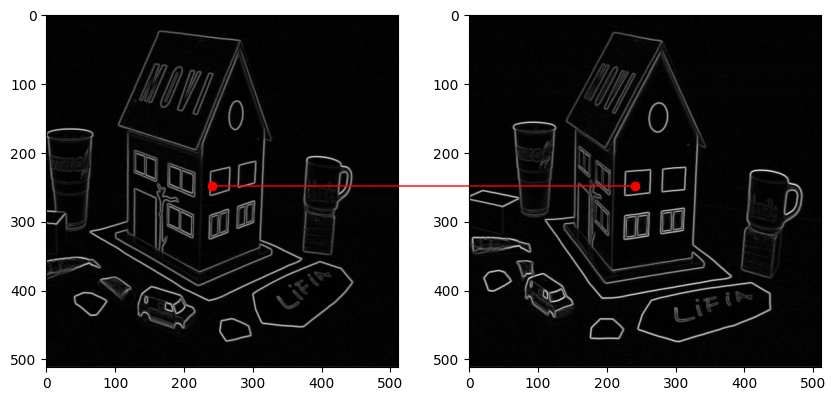

In [6]:
import numpy as np
from scipy.signal import correlate2d
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt

# Define Sobel filters
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

def apply_sobel_filter(image, kernel):
    return correlate2d(image, kernel, mode='same')

def compute_gradient(image):
    gradient_x = apply_sobel_filter(image, sobel_x)
    gradient_y = apply_sobel_filter(image, sobel_y)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    return magnitude

def normalized_cross_correlation(image1, image2):
    assert image1.shape == image2.shape, "Images must be the same size"
    mean1 = np.mean(image1)
    mean2 = np.mean(image2)
    std1 = np.std(image1)
    std2 = np.std(image2)
    normalized_image1 = (image1 - mean1) / std1
    normalized_image2 = (image2 - mean2) / std2
    return correlate2d(normalized_image1, normalized_image2, mode='same')

def compute_disparity(correlation):
    # Find the index of the maximum correlation for each row
    max_indices = np.argmax(correlation, axis=1)

    # Create a 2D grid of column indices
    cols = np.arange(correlation.shape[1])

    # Subtract the column index of the maximum correlation from each column index
    disparity = cols - max_indices[:, np.newaxis]

    return disparity

# Load your images
image1 = plt.imread('house1.pgm')
image2 = plt.imread('house2.pgm')

# Apply Sobel filter to the images
image1_sobel = compute_gradient(image1)
image2_sobel = compute_gradient(image2)

# Compute normalized cross-correlation
correlation = normalized_cross_correlation(image1_sobel, image2_sobel)

# Compute similarity score
similarity_score = np.sum(correlation)

# Compute maximum possible score
max_score = image1_sobel.size * np.max(correlation)

# Compute similarity percentage
similarity_percentage = (similarity_score / max_score) * 100

print(f"Similarity percentage: {similarity_percentage}%")

# Compute disparity
disparity = compute_disparity(correlation)
print(f"Disparity: {disparity}")

# Find the point of maximum correspondence
y, x = np.unravel_index(np.argmax(correlation), correlation.shape)

# Plot the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the images
ax[0].imshow(image1_sobel, cmap='gray')
ax[1].imshow(image2_sobel, cmap='gray')

# Mark the point of maximum correspondence
ax[0].plot(x, y, 'ro')
ax[1].plot(x, y, 'ro')

# Draw a line between the corresponding points
con = ConnectionPatch(xyA=(x, y), xyB=(x, y), coordsA="data", coordsB="data", axesA=ax[1], axesB=ax[0], color="red")
ax[1].add_artist(con)

plt.show()

### 2. carte de disparite
1. **Calcul de la Carte de Disparité**
   - Une double boucle parcourt les pixels de l'image 1 (gauche) après avoir exclu une marge de la taille de la fenêtre pour laquelle la recherche de correspondance n'est pas effectuée.
   - Pour chaque pixel, une recherche de correspondance est effectuée dans une fenêtre autour du pixel correspondant de l'image 2 (droite) en utilisant une fenêtre glissante.
   - La corrélation entre la fenêtre de l'image gauche et les différentes fenêtres de l'image droite est calculée à l'aide de la fonction `np.corrcoef`.
   - La disparité (différence d'indice de colonne) correspondant à la meilleure corrélation est enregistrée dans la carte de disparité.

2. **Affichage de la Carte de Disparité**
   - La carte de disparité résultante est affichée en utilisant `plt.imshow`. Les valeurs de disparité sont représentées par des couleurs avec une barre de couleur associée pour la référence.

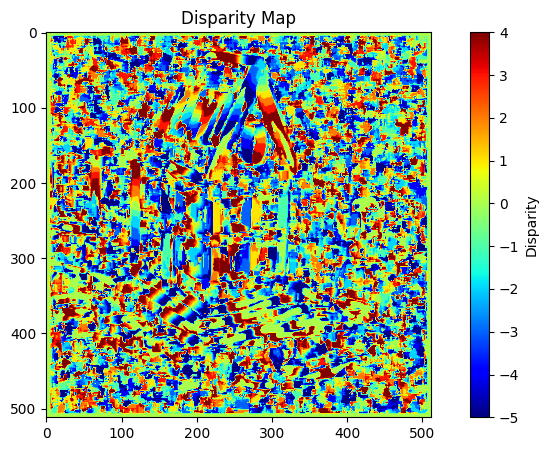

In [8]:
import numpy as np
from scipy.signal import correlate2d
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt

# Define Sobel filters
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

def apply_sobel_filter(image, kernel):
    return correlate2d(image, kernel, mode='same')

def compute_gradient(image):
    gradient_x = apply_sobel_filter(image, sobel_x)
    gradient_y = apply_sobel_filter(image, sobel_y)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    return magnitude

# Load your images
image1 = plt.imread('house1.pgm')
image2 = plt.imread('house2.pgm')

# Apply Sobel filter to the images
image1_sobel = compute_gradient(image1)
image2_sobel = compute_gradient(image2)

# Compute normalized cross-correlation and disparity
window_size = 5
disparity_map = np.zeros_like(image1_sobel)
for y in range(window_size, image1_sobel.shape[0] - window_size):
    for x in range(window_size, image1_sobel.shape[1] - window_size):
        best_offset = 0 
        prev_corr = 0
        for offset in range(-window_size, window_size):
            left_window = image1_sobel[y - window_size:y + window_size, x - window_size:x + window_size]
            right_window = image2_sobel[y - window_size:y + window_size, (x + offset) - window_size:(x + offset) + window_size]
            if right_window.shape[1] != window_size*2:
                continue
            corr = np.corrcoef(left_window.reshape(-1), right_window.reshape(-1))[0, 1]
            if corr > prev_corr:
                prev_corr = corr
                best_offset = offset
        disparity_map[y, x] = best_offset

# Display the disparity map
plt.figure(figsize=(10, 5))
plt.imshow(disparity_map, cmap='jet')
plt.colorbar(label='Disparity')
plt.title('Disparity Map')
plt.show()


### 3.reconstruction 3D

**Définition des Paramètres de la Caméra Stéréo**
   - Les paramètres de la caméra stéréo, tels que la longueur focale et la base, sont définis. 

1. **Calcul de la Carte de Profondeur**
   - La carte de profondeur est calculée à partir de la carte de disparité en utilisant la relation géométrique entre la profondeur, la longueur focale et la base stéréo.

2. **Création du Nuage de Points 3D**
   - À partir de la carte de profondeur, un nuage de points 3D est créé en assignant des coordonnées 3D à chaque pixel en fonction de sa position et de sa profondeur dans l'image.

3. **Affichage du Modèle 3D**
   - Le nuage de points 3D est affiché en utilisant une visualisation 3D avec la bibliothèque Matplotlib.


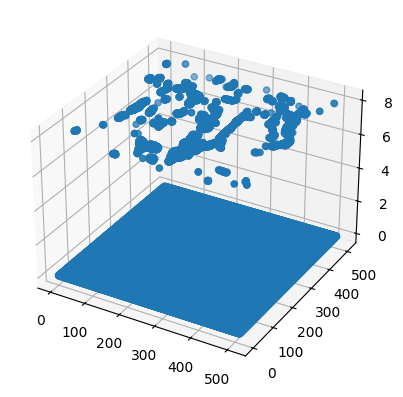

In [1]:
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Load your stereo images
image1 = cv2.imread('house1.pgm', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('house2.pgm', cv2.IMREAD_GRAYSCALE)

# Compute disparity map
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(image1, image2)

# Define stereo camera parameters
focal_length = 0.8  # example value, you should use your own value
baseline = 1.0  # example value, you should use your own value

# Calculate depth map from disparity map
depth_map = focal_length * baseline / (disparity + 1e-10)  # add a small constant to avoid division by zero

# Create a 3D point cloud
height, width = depth_map.shape
x = np.linspace(0, width, width)
y = np.linspace(0, height, height)
x, y = np.meshgrid(x, y)
z = depth_map
points_3d = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

# Display the 3D model
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])
plt.show()